## Installing packages

In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install fosforml==1.1.6

In [39]:
!pip install yellowbrick

## Importing packages

In [1]:
from fosforml import *
from fosforml.constants import MLModelFlavours
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

In [40]:
#Importing the Libraries

import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## Getting data from Github and moving to SF

In [ ]:
# URL of the CSV file on GitHub
#url = 'https://github.com/aksh301091/fdc_akshaya_git/blob/91a0b3faf99492355d3816919fbf79de434926c3/ME_CASINO_PRJ/customer_table.csv'
#'https://raw.githubusercontent.com/username/repository/branch/filename.csv'

In [2]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [3]:
# Read the CSV file into a DataFrame
cust_df = pd.read_csv('customer_table.csv')
#trx_df = pd.read_csv('transaction_table.csv')

#cust_df.info()

In [7]:
t1_df = pd.read_csv('trx_1.csv')
t2_df = pd.read_csv('trx_2.csv')
t3_df = pd.read_csv('trx_3.csv')

In [5]:
type(cust_df)

pandas.core.frame.DataFrame

In [ ]:
cust_sfdf = my_session.createDataFrame(cust_df)
cust_sfdf.write.mode("overwrite").save_as_table("casino_customers")
#my_session.table("casino_customers").show()

In [11]:
#inter_df = pd.concat([t1_df, t2_df, t2_df, ignore_index=True)
inter_df = t1_df._append(t2_df,ignore_index=True)

#for trx_df in (t1_df, t2_df, t3_df):
#    trx_df =  trx_df.append(df, ignore_index=True)
#trx_df

In [12]:
trx_df = inter_df._append(t3_df, ignore_index=True)

In [15]:
trx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   TRANSACTION_ID                      200000 non-null  int64  
 1   DATE                                200000 non-null  object 
 2   PLAYER_ID                           200000 non-null  int64  
 3   PLAYER_AGE                          200000 non-null  int64  
 4   PLAYER_GENDER                       200000 non-null  object 
 5   HOME_COUNTRY                        200000 non-null  object 
 6   HOME_CITY                           200000 non-null  object 
 7   GAME_CATEGORY                       200000 non-null  object 
 8   GAME_NAME                           200000 non-null  object 
 9   TABLE_MINIMUM_BET                   200000 non-null  float64
 10  IS_PREMIUM_PLAYER                   200000 non-null  bool   
 11  DURATION_SPENT            

In [ ]:
cust

In [14]:
trx_sfdf = my_session.createDataFrame(trx_df)
trx_sfdf.write.mode("overwrite").save_as_table("casino_transactions")

## Reading data from SF 

In [16]:
## Reading data from SF 

table_name = 'CASINO_CUSTOMERS'
customer_df = my_session.sql("select * from {}".format(table_name))
customer_df = customer_df.to_pandas()
type(customer_df)

pandas.core.frame.DataFrame

In [17]:
table_name = 'CASINO_TRANSACTIONS'
transaction_df = my_session.sql("select * from {}".format(table_name))
transaction_df = transaction_df.to_pandas()
type(transaction_df)

pandas.core.frame.DataFrame

## Data Preparation

In [32]:
# Date transformation data type

customer_df['DATE_FIRST_VISIT'] = pd.to_datetime(customer_df['DATE_FIRST_VISIT'], format = 'mixed')
customer_df['DATE_LAST_VISIT'] = pd.to_datetime(customer_df['DATE_LAST_VISIT'], format = 'mixed')
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], format = 'mixed')

In [34]:
print(customer_df.info())
print(transaction_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int16         
 1   AGE                                      10000 non-null  int8          
 2   GENDER                                   10000 non-null  int64         
 3   HOME_COUNTRY                             10000 non-null  int64         
 4   HOME_CITY                                10000 non-null  int64         
 5   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 6   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 7   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int8          
 8   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 9   AVERAGE_DURATION_PER_VISIT              

In [ ]:
# Adding new features for better classification
customer_df['VISIT_FREQUENCY'] = customer_df['TOTAL_NUMBER_OF_VISITS'] / ((pd.to_datetime(customer_df['DATE_LAST_VISIT']) - 
                                                                           pd.to_datetime(customer_df['DATE_FIRST_VISIT'])).dt.days + 1)

## Data Exploration

In [18]:
# Descriptive statistics for customer data
print(customer_df.describe(include='all'))
print(transaction_df.describe(include='all'))

          PLAYER_ID           AGE GENDER HOME_COUNTRY  HOME_CITY  \
count   10000.00000  10000.000000  10000        10000      10000   
unique          NaN           NaN      2            4         31   
top             NaN           NaN   Male           US  Singapore   
freq            NaN           NaN   5009         2527       2485   
mean     5000.50000     60.339200    NaN          NaN        NaN   
std      2886.89568     14.311612    NaN          NaN        NaN   
min         1.00000     21.000000    NaN          NaN        NaN   
25%      2500.75000     50.000000    NaN          NaN        NaN   
50%      5000.50000     63.000000    NaN          NaN        NaN   
75%      7500.25000     73.000000    NaN          NaN        NaN   
max     10000.00000     80.000000    NaN          NaN        NaN   

       DATE_FIRST_VISIT DATE_LAST_VISIT  TOTAL_NUMBER_OF_VISITS  \
count             10000           10000            10000.000000   
unique              326             316          

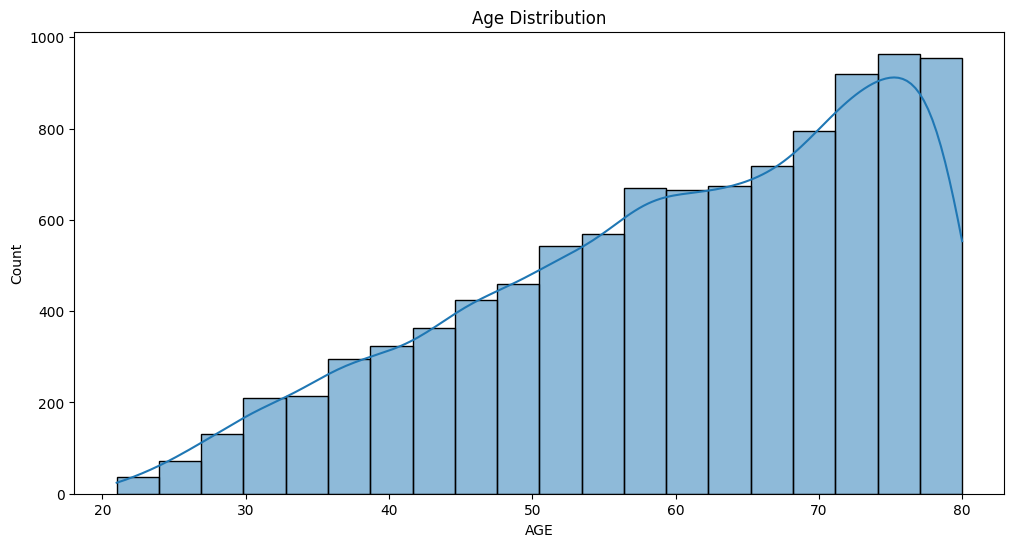

In [20]:
# Plotting distribution of age
plt.figure(figsize=(12, 6))
sns.histplot(customer_df['AGE'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

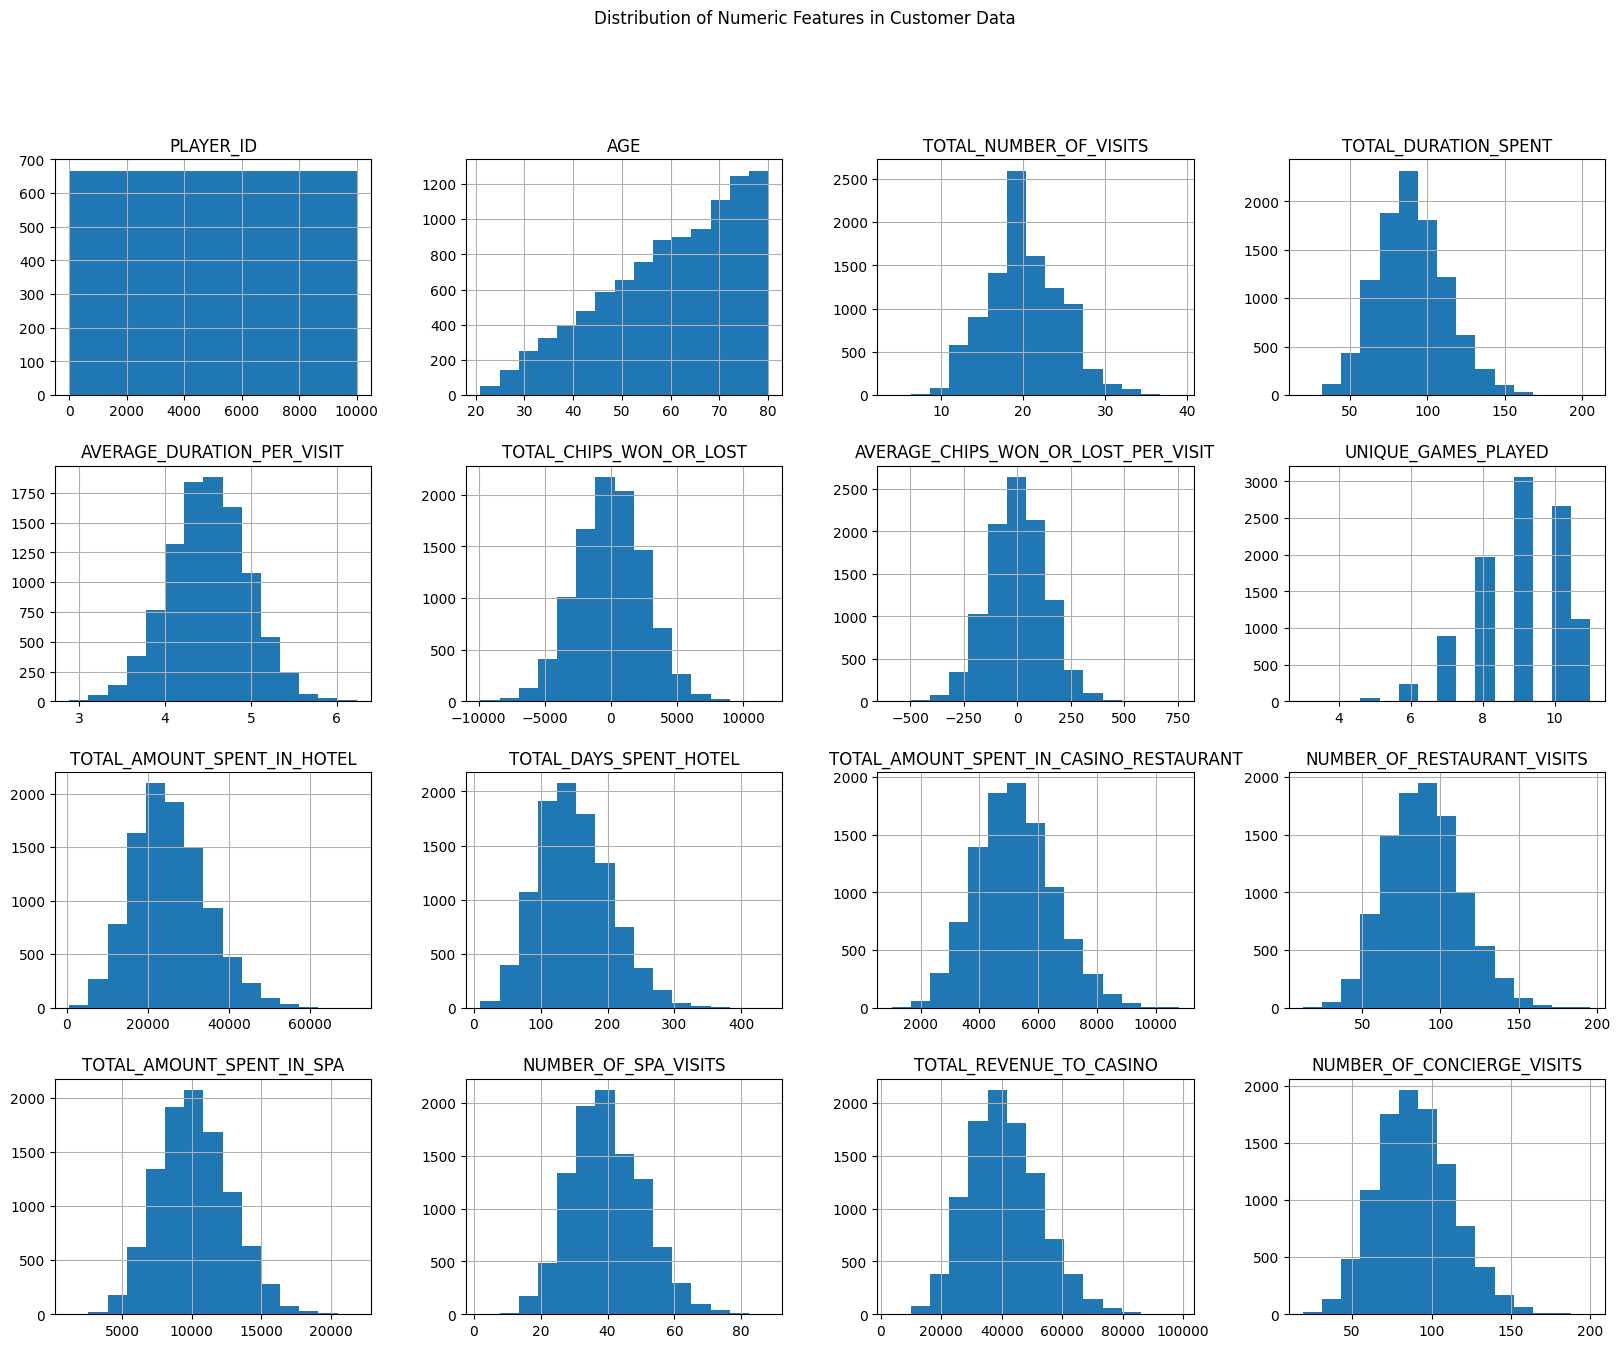

In [21]:
# Plotting distribution for numeric features in customer data
customer_df.hist(bins=15, figsize=(20, 15))
plt.suptitle('Distribution of Numeric Features in Customer Data')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

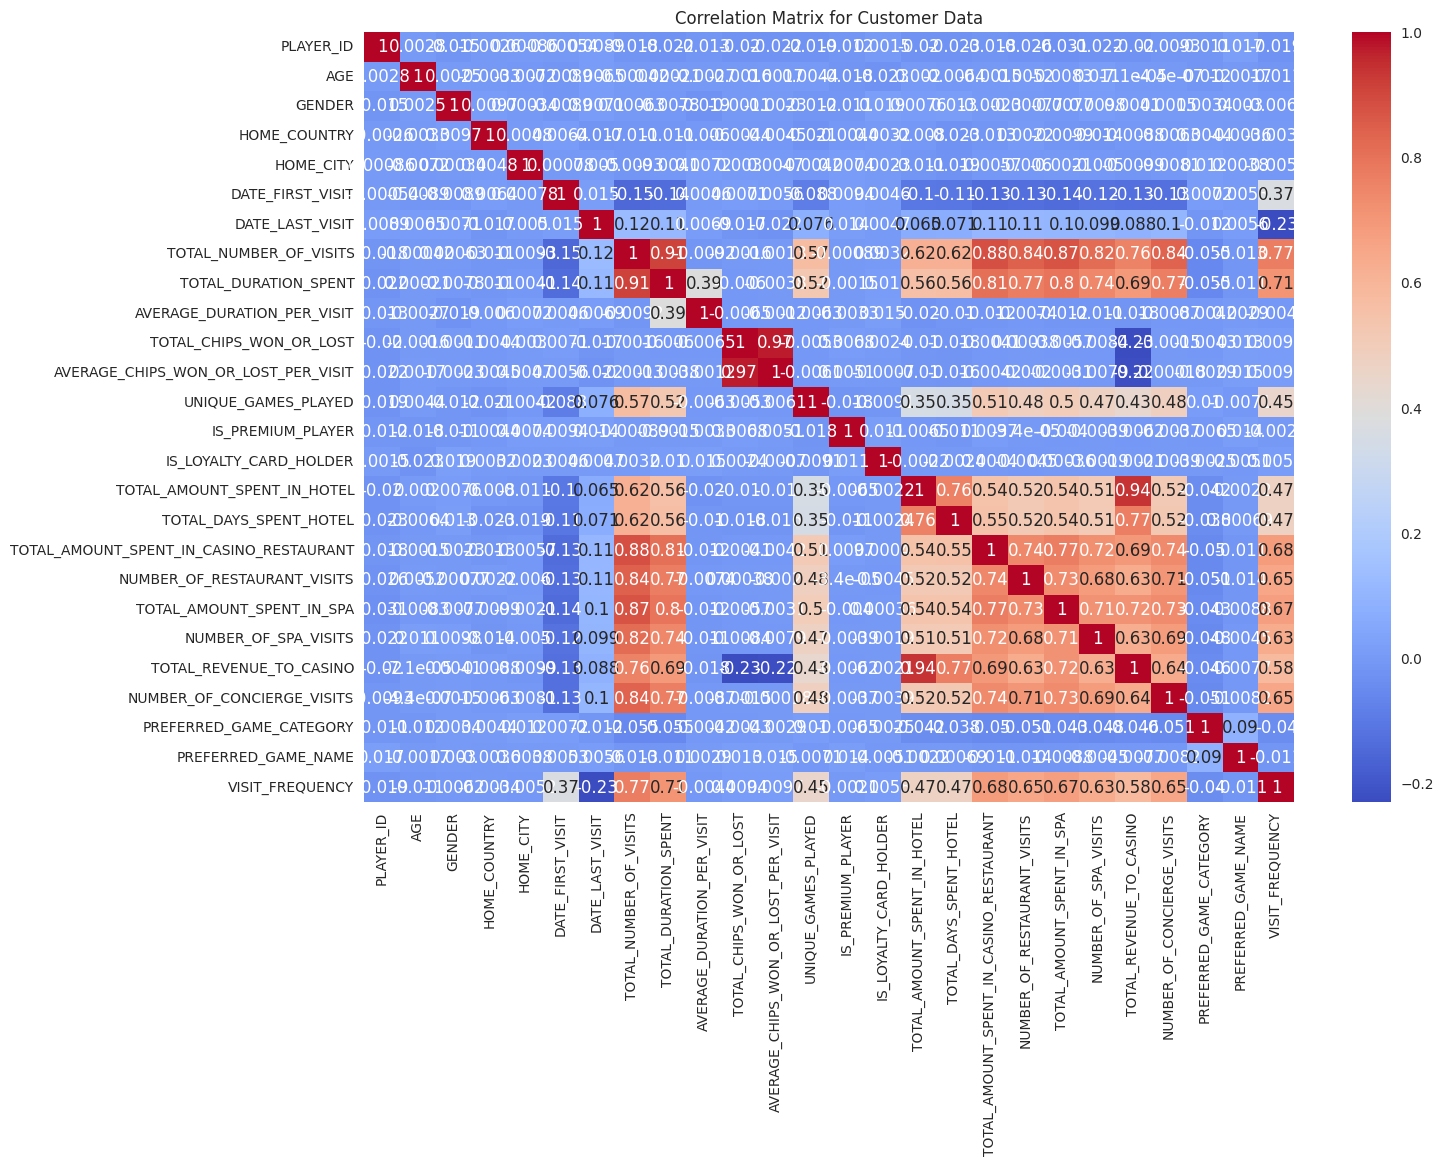

In [41]:
# Correlation matrix for customer_df
correlation_matrix = customer_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Customer Data')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

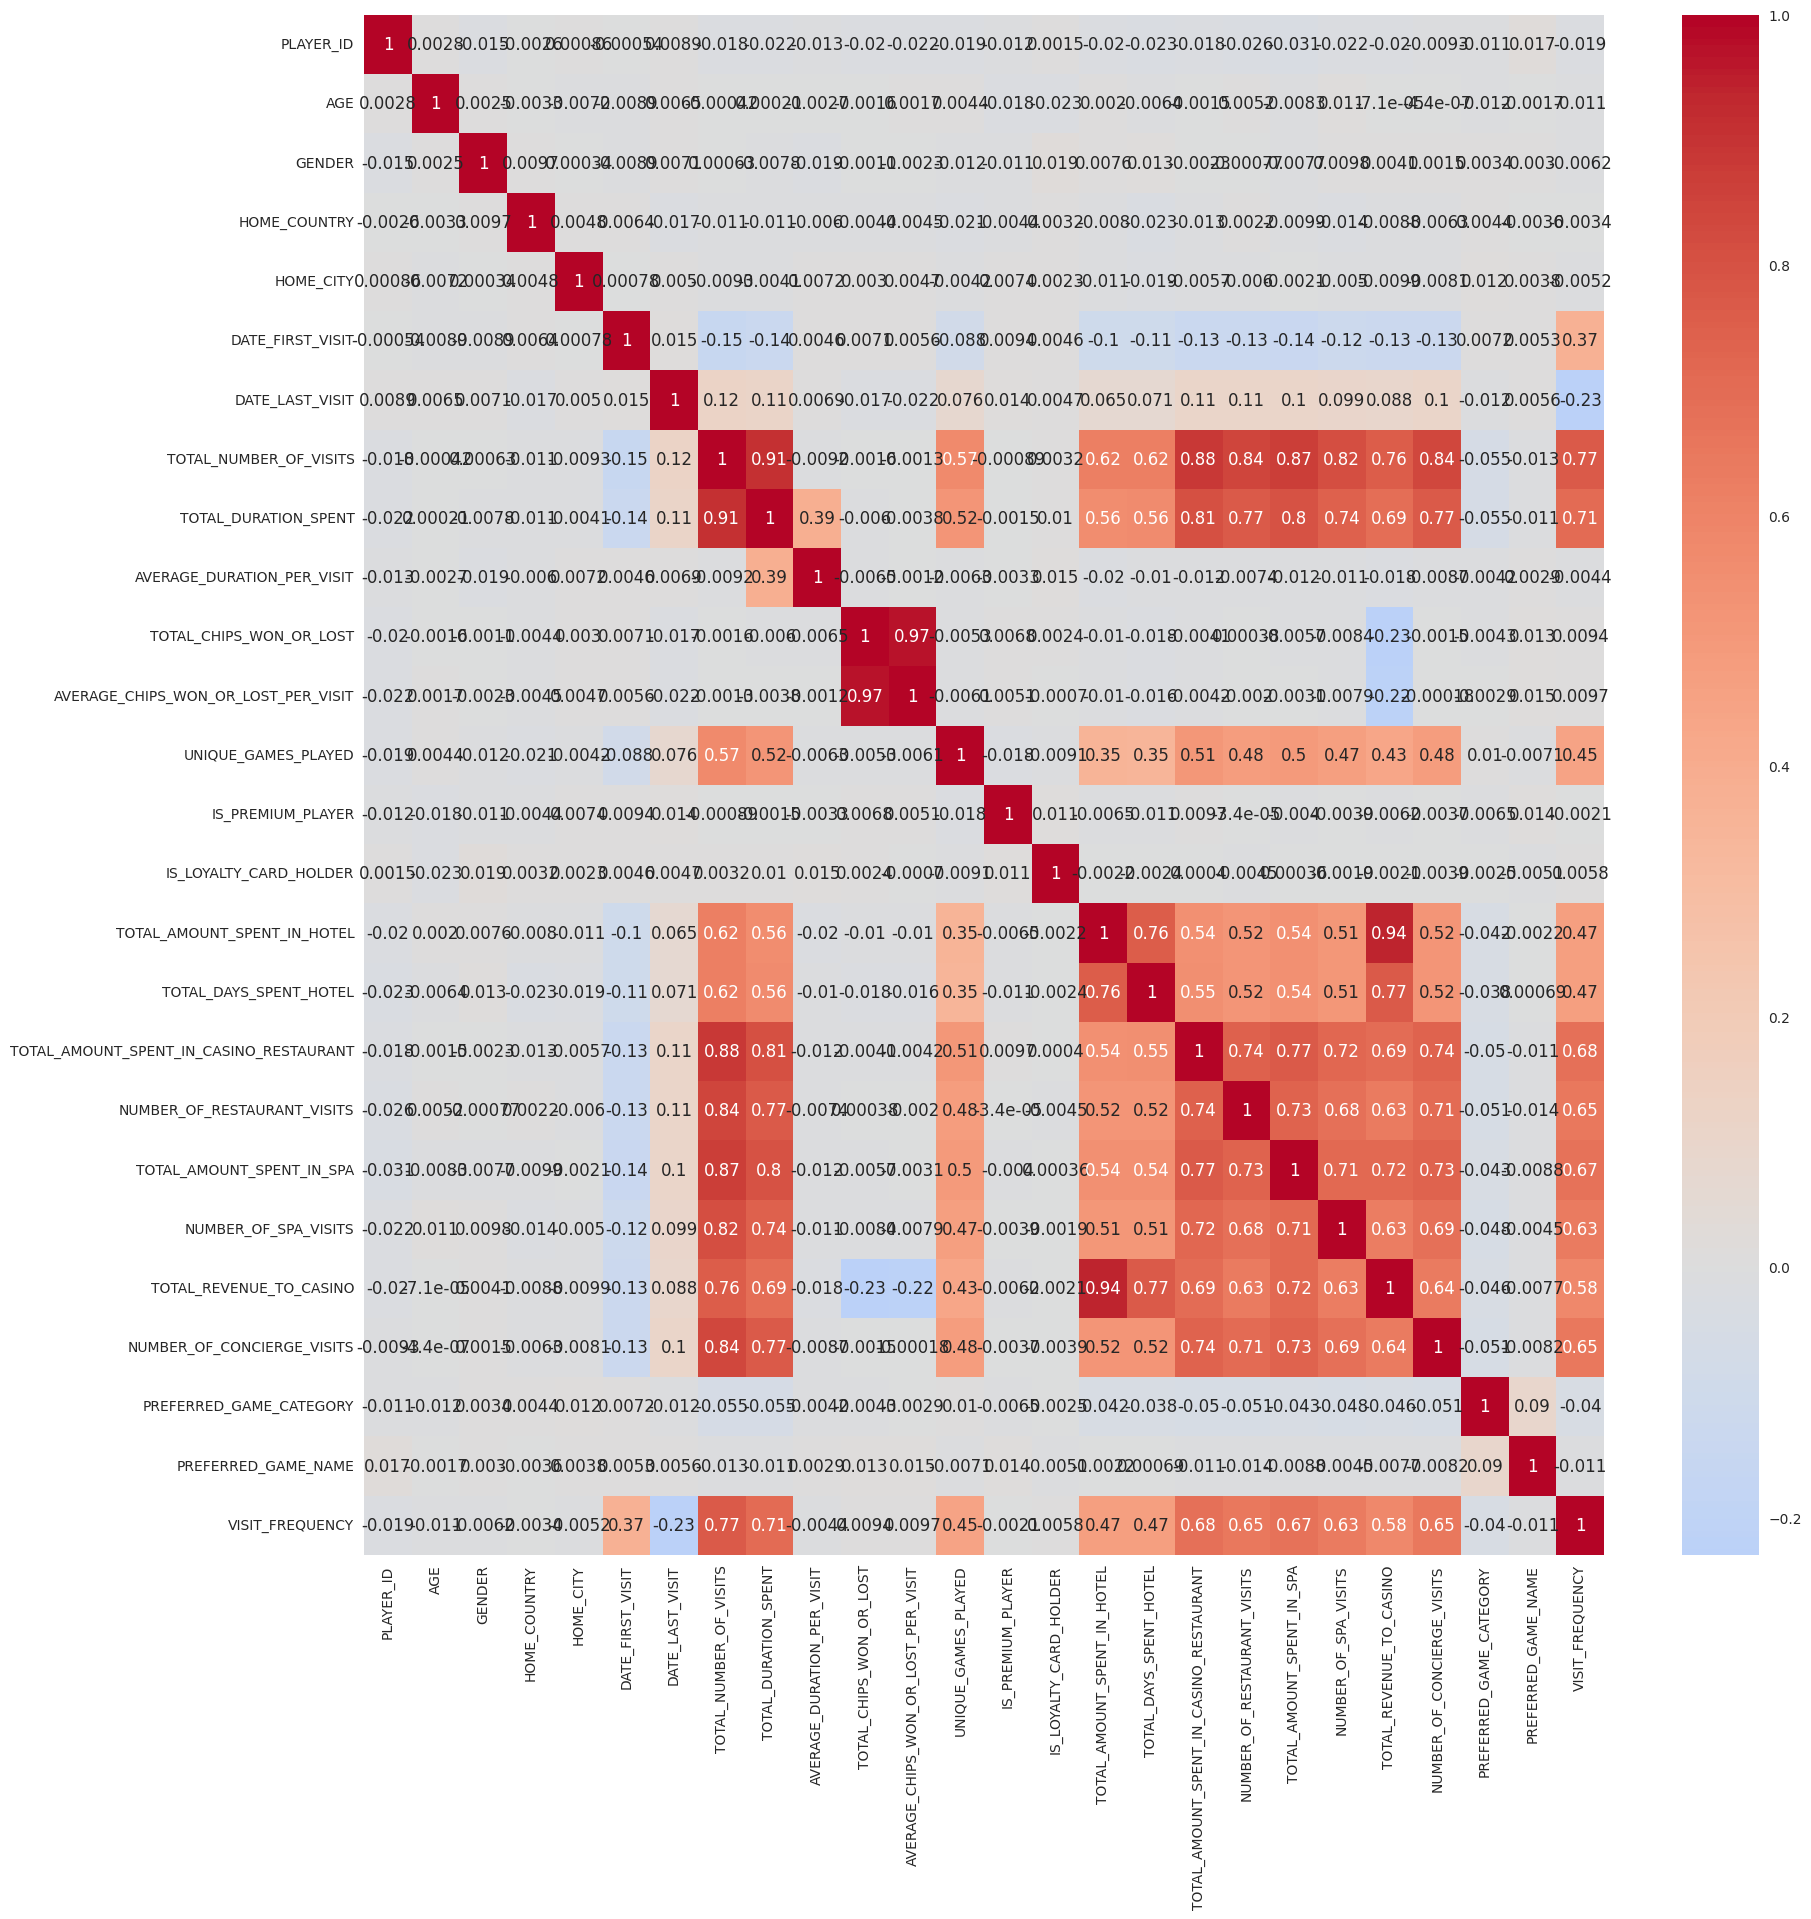

In [43]:
corrmat= customer_df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap='coolwarm', center=0)

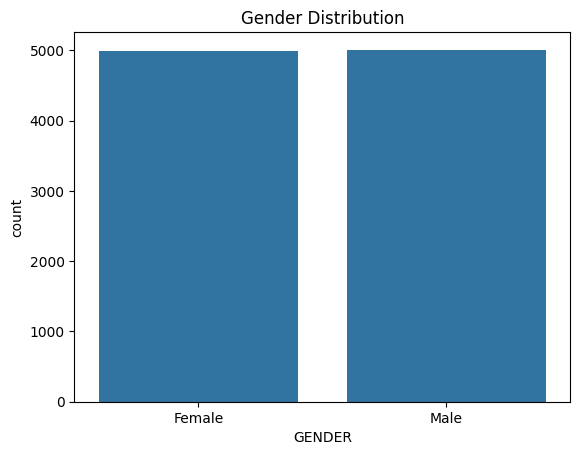

In [23]:
# Plotting categorical features against target variable
sns.countplot(x='GENDER', data=customer_df)
plt.title('Gender Distribution')
plt.show()

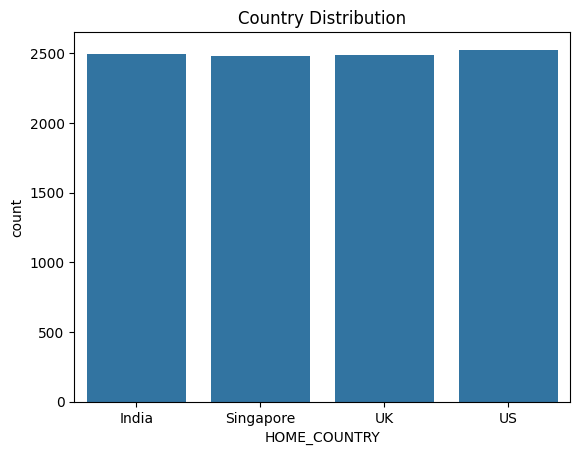

In [24]:
sns.countplot(x='HOME_COUNTRY', data=customer_df)
plt.title('Country Distribution')
plt.show()

## Pre-processing

In [25]:
# Checking for missing values
print(customer_df.isna().sum())

PLAYER_ID                                  0
AGE                                        0
GENDER                                     0
HOME_COUNTRY                               0
HOME_CITY                                  0
DATE_FIRST_VISIT                           0
DATE_LAST_VISIT                            0
TOTAL_NUMBER_OF_VISITS                     0
TOTAL_DURATION_SPENT                       0
AVERAGE_DURATION_PER_VISIT                 0
TOTAL_CHIPS_WON_OR_LOST                    0
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT        0
UNIQUE_GAMES_PLAYED                        0
IS_PREMIUM_PLAYER                          0
IS_LOYALTY_CARD_HOLDER                     0
TOTAL_AMOUNT_SPENT_IN_HOTEL                0
TOTAL_DAYS_SPENT_HOTEL                     0
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT    0
NUMBER_OF_RESTAURANT_VISITS                0
TOTAL_AMOUNT_SPENT_IN_SPA                  0
NUMBER_OF_SPA_VISITS                       0
TOTAL_REVENUE_TO_CASINO                    0
NUMBER_OF_

In [26]:
# Fill missing values or drop them if appropriate
customer_df = customer_df.dropna()  # Here we simply drop missing values

In [28]:
# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in ['GENDER', 'HOME_COUNTRY', 'HOME_CITY', 'PREFERRED_GAME_CATEGORY', 'PREFERRED_GAME_NAME', 'IS_PREMIUM_PLAYER', 'IS_LOYALTY_CARD_HOLDER']:
    le = LabelEncoder()
    customer_df[column] = le.fit_transform(customer_df[column])
    label_encoders[column] = le

## Feature Engineering

## Classification Model training

In [ ]:
# Preparing data for classification models

X = customer_df.drop(columns=['PLAYER_ID', 'DATE_FIRST_VISIT', 'DATE_LAST_VISIT'])
y = customer_df['IS_PREMIUM_PLAYER']  # Assuming the target variable is premium membership